# Исследование распределений активаций в CNN

### Импортируем нужые библиотеки

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Загрузка датасета
Исследование будем проводить на датасете __CIFAR-10__, состоящем из цветных изображений размером 32x32, поделенных на 10 классов (самолетики, машинки, птички, кошечки, олени, собачки, лягушки, лошадки, кораблики и  грузовички)

In [22]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465),
                          (0.247, 0.243, 0.261))])

batch_size = 64

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


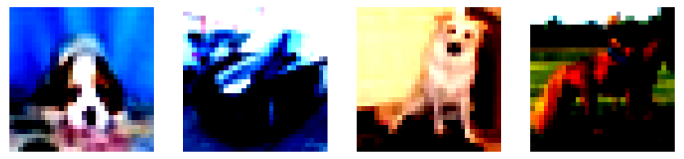

In [23]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for ax, img in zip(axes, next(iter(train_loader))[0].permute(0, 2, 3, 1)):
    ax.imshow(img)
    ax.axis('off')
plt.show()

### Фукнции для обучения и оценки качества моделей

In [24]:
from tqdm.auto import tqdm

def train_epoch(model, optimizer):
    model.train()
    criterion = nn.CrossEntropyLoss()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        output = model(data)

        loss = criterion(output, target)

        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()

def evaluate(dataloader, model):
    model.eval()
    
    criterion = nn.CrossEntropyLoss()
    
    total_loss = 0.0
    total_accuracy = 0.0
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)

            output = model(data)

            loss = criterion(output, target)
            total_loss += loss

            accuracy = (target == output.argmax(dim=1)).float().mean()
            total_accuracy += accuracy

    return total_loss / len(dataloader), total_accuracy / len(dataloader)
    

def train(model, optimizer, num_epochs, verbose=True):
    test_losses = []
    train_losses = []
    test_accuracies = []
    train_accuracies = []
    epoch_range = range(num_epochs)
    if not verbose:
        epoch_range = tqdm(epoch_range)
    for epoch in epoch_range:
        train_epoch(model, optimizer)
        
        train_loss, train_acc = evaluate(train_loader, model)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        
        test_loss, test_acc = evaluate(test_loader, model)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)
        if verbose:
            print(
                'Epoch: {0:d}/{1:d}. Loss (Train/Test): {2:.3f}/{3:.3f}. Accuracy (Train/Test): {4:.3f}/{5:.3f}'.format(
                    epoch + 1, num_epochs, train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
                )
        )
    return train_losses, train_accuracies, test_losses, test_accuracies

### Базовая модель
В качестве архитектуры для конструктора сетей возьмем __ResNet__.

Базовым блоком в сети является следующая последовательность слоев:

Conv2D -> BatchNorm -> ReLU -> Conv2D -> BatchNorm -> + ResConnection -> ReLU

Из такого базового блока можно легко убрать BatchNorm или ResConnection, поменять BatchNorm на Dropout.

Будем использовать 3 слоя, каждый из которых состоит из N подобных блоков (в каждом слое у сверток одинаковое количество фильтров)

Таким образом архитектура будет описываться кофигурацией:

\[ (n_blocks1, n_filters1,), (n_blocks2, n_filters2), (n_blocks3, n_filters3) \]

Замечание:
- Каждая из сверток имеет kernel_size=3x3
- Первая свертка в каждом слое имеет stride=2 для уменьшения размера изображения

In [25]:
from collections import OrderedDict
import math

def conv3x3(in_channels, out_channels, stride=1, bias=False):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=bias)


class BaseBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, batch_norm=True, res_connect=True, dropout=None, downsample=None):
        super(BaseBlock, self).__init__()
        self.batch_norm = batch_norm
        self.res_connect = res_connect
        self.dropout = dropout
        self.activations = []
        
        self.conv1 = conv3x3(in_channels, out_channels, stride, bias=(not self.batch_norm))
        if self.batch_norm:
            self.bn1 = nn.BatchNorm2d(out_channels)
        if self.dropout is not None:
            self.do1 = nn.Dropout(self.dropout)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels, bias=(not self.batch_norm))
        if self.batch_norm:
            self.bn2 = nn.BatchNorm2d(out_channels)
        if self.dropout is not None:
            self.do2 = nn.Dropout(self.dropout)
        if self.res_connect:
            self.downsample = downsample

    def forward(self, x):
        self.activations = []
        if self.res_connect:
            residual = x
        out = self.conv1(x)
        if self.batch_norm:
            out = self.bn1(out)
        if self.dropout:
            out = self.do1(out)
        out = self.relu(out)
        self.activations.append(out)
        out = self.conv2(out)
        if self.batch_norm:
            out = self.bn2(out)
        if self.dropout:
            out = self.do2(out)
        if self.res_connect and self.downsample:
            residual = self.downsample(x)
        if self.res_connect:
            out += residual
        out = self.relu(out)
        self.activations.append(out)
        return out


class CustomCNN(nn.Module):
    def __init__(self, block, layers_config=[(3, 16), (3, 32), (3, 64)], batch_norm=True,
                 res_connect=True, dropout=None, init=None, num_classes=10):
        super(CustomCNN, self).__init__()
        self.batch_norm = batch_norm
        self.res_connect = res_connect
        self.dropout = dropout
        self.activations = []
        
        in_channels = layers_config[0][1]
        self.conv = conv3x3(3, in_channels, bias=(not self.batch_norm))
        if self.batch_norm:
            self.bn = nn.BatchNorm2d(in_channels)
        if self.dropout is not None:
            self.do = nn.Dropout(self.dropout)
        self.relu = nn.ReLU(inplace=True)
        
        layers = []
        for i, (blocks, out_channels) in enumerate(layers_config):
            layers.append(
                self._make_layer(block, in_channels, out_channels, blocks, stride=(2 if i else 1),
                                 batch_norm=self.batch_norm, res_connect=self.res_connect, dropout=self.dropout))
            in_channels = out_channels
        # self.layers = nn.Sequential(*layers)
        self.layer1 = layers[0]
        self.layer2 = layers[1]
        self.layer3 = layers[2]
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(out_channels, num_classes)

        self._init_weights(init)

    def _make_layer(self, block, in_channels, out_channels, blocks, stride=1, batch_norm=True, res_connect=True, dropout=None):
        downsample = None
        if (stride != 1) or (in_channels != out_channels):
            downsample = []
            downsample.append(('conv', conv3x3(in_channels, out_channels, stride=stride, bias=(not batch_norm))))
            if batch_norm:
                downsample.append(('bn', nn.BatchNorm2d(out_channels)))
            if dropout is not None:
                downsample.append(('do', nn.Dropout(self.dropout)))
            downsample = nn.Sequential(OrderedDict(downsample))
        layers = []
        layers.append(block(in_channels, out_channels, stride, batch_norm, res_connect, dropout, downsample))
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels,
                                batch_norm=batch_norm, res_connect=res_connect, dropout=dropout))
        return nn.Sequential(*layers)
    
    def _init_weights(self, init=None):
        if init is None:
            return
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if init == 'kaiming_uniform':
                    nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                    # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                    # stdv = 1 / math.sqrt(n)
                    # m.weight.data.uniform_(-stdv, stdv)
                elif init == 'kaiming_normal':
                    nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                elif init == 'xavier_uniform':
                    nn.init.xavier_uniform_(m.weight)
                elif init == 'xavier_normal':
                    nn.init.xavier_normal_(m.weight)
                elif init == 'zero':
                    m.weight.data.zero_()
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        self.activations = []
        out = self.conv(x)
        if self.batch_norm:
            out = self.bn(out)
        if self.dropout:
            out = self.do(out)
        out = self.relu(out)
        self.activations.append(out)
        # out = self.layers(out)
        
        out = self.layer1(out)
        for m in self.layer1.modules():
            if isinstance(m, BaseBlock):
                self.activations.append(m.activations)
        out = self.layer2(out)
        for m in self.layer2.modules():
            if isinstance(m, BaseBlock):
                self.activations.append(m.activations)
        out = self.layer3(out)
        for m in self.layer3.modules():
            if isinstance(m, BaseBlock):
                self.activations.append(m.activations)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


### Кофигурации сетей
Будем сравнивать следующие конфигурации сетей:
- Широкая (32, 64, и 128 фильтров в каждом слое соответственно) __VS__ Узкая (8, 16, 32 фильтра соответственно)
- Глубокая (из 5 блоков в каждом слое) __VS__ Мелкая (из 3 блоков в каждом слое)
- C BatchNorm и ResConnection __VS__ Только c BatchNorm
- C BatchNorm и ResConnection __VS__ Только c ResConnection
- С Dropout и ResConnection __VS__ C BatchNorm и ResConnection
- С Dropout и ResConnection __VS__ Только с ResConnection
- С XavierUniform инициализацией __VS__ C KaimingUniform инициализацией
- С XavierNormal инициализацией __VS__ С KaimingNormal инициализацией
- C оптимизатором Adam __VS__ C оптимизатором SGD

Не будем рассматривать сети в которых не присутствует ни BatchNorm, ни ResConnection (они плохо обучаются)

В словаре ниже описана default конфигурация (ResNet-20). Далее описаны различные конфигурации для экспериментов в виде изменений, вносимых в default конфигурацию.

In [26]:
default_config = {
    'cnn_config': {'layers_config': [(3, 16), (3, 32), (3, 64)], 'batch_norm': True,
                   'res_connect': True, 'dropout': None, 'init': None},
    'optimizer': {'class': torch.optim.Adam,
                  'params': {'lr': 1e-3, 'weight_decay': 1e-4}
                  }
}

model_configs = {
               'default': {'cnn_config': {}},
               'wide': {'cnn_config': {'layers_config': [(3, 32), (3, 64), (3, 128)]}},
               'narrow': {'cnn_config': {'layers_config': [(3, 8), (3, 16), (3, 32)]}},
               'deep': {'cnn_config': {'layers_config': [(5, 16), (5, 32), (5, 64)]}},
               'shallow': {'cnn_config': {'layers_config': [(2, 16), (2, 32), (2, 64)]}},
               'dropout': {'cnn_config': {'batch_norm': False, 'dropout': 0.3}},
               'batch_norm': {'cnn_config': {'res_connect': False}},
               'res_connect': {'cnn_config': {'batch_norm': False}},
#                'zero_init': {'cnn_config': {'init': 'zero'}},
               'xavier_uniform_init': {'cnn_config': {'init': 'xavier_uniform'}},
               'kaiming_uniform_init': {'cnn_config': {'init': 'kaiming_uniform'}},
               'xavier_normal_init': {'cnn_config': {'init': 'xavier_normal'}},
               'kaiming_normal_init': {'cnn_config': {'init': 'kaiming_normal'}},
               'sgd': {'cnn_config': {},
                       'optimizer': {'class': torch.optim.SGD,
                                     'params': {'lr':1e-2, 'weight_decay': 1e-4, 'momentum': 0.9}
                                     }
                       },
               'deep-bn': {'cnn_config': {'layers_config': [(5, 16), (5, 32), (5, 64)],
                                          'res_connect': False}},
               'shallow-bn': {'cnn_config': {'layers_config': [(2, 16), (2, 32), (2, 64)],
                                             'res_connect': False}}
}

add_configs = {}

### Обучение моделей

Каждая модель обучается 15 эпох, на функцию потерь CrossEntropyLoss. По умолчанию используется оптимизатор Adam с параметрами learning rate = 1e-3, weight_decay = 1e-4, веса сверток инициализируются KaimingUniform инициализацией.

In [27]:
# from copy import deepcopy
# from tqdm.contrib.telegram import tqdm as tqdm_telegram
# token = ''
# chat_id = ''

# for label, model_config in tqdm_telegram(list(add_configs.items()),
#                                          token=token, chat_id=chat_id):
#     config = deepcopy(default_config)
#     config['cnn_config'].update(**model_config['cnn_config'])
#     if 'optimizer' in model_config:
#         config['optimizer'] = model_config['optimizer']
#     model = CustomCNN(BaseBlock, **config['cnn_config']).to(device)
#     optimizer = config['optimizer']['class'](model.parameters(), **config['optimizer']['params'])
#     stat = train(model, optimizer, 15, verbose=False)
#     save_dict = {'stat': stat, 'config': config, 'state_dict': model.state_dict()}
#     torch.save(save_dict, f"saved_models/{label}")

Проверим, что все модели обучились:

In [30]:
for name in model_configs:
    save_dict = torch.load(f"saved_models/{name}")
    print(f"{name} - {save_dict['stat'][-1][-1].item():.4f}")

default - 0.7842
wide - 0.8234
narrow - 0.7650
deep - 0.8249
shallow - 0.7952
dropout - 0.7498
batch_norm - 0.8034
res_connect - 0.7882
xavier_uniform_init - 0.8043
kaiming_uniform_init - 0.8052
xavier_normal_init - 0.8211
kaiming_normal_init - 0.7834
sgd - 0.7823
deep-bn - 0.7345
shallow-bn - 0.8035


### Функции для отрисовки графиков

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def centers(edges):
    centers = edges[:-1] + (edges[1:]-edges[:-1]) / 2
    return centers

def compare_configs(config1, config2, test_batch, title=None):
    fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(11, 5))
    subtitles = ['Layer 0', 'Layer 1', 'Layer 2', 'Layer 3']
    fig.suptitle(title, fontsize=14)
    for i, subtitle in enumerate(subtitles):
        axes[0, i].set_title(subtitle)
        axes[1, i].set_xlabel('activation')
        axes[0, i].grid()
        axes[1, i].grid()
    
    print('Number of zero activations:')
    for i, name in enumerate([config1, config2]):
        axes[i, 0].set_ylabel(name)
        save_dict = torch.load(f"saved_models/{name}")
        model = CustomCNN(BaseBlock, **save_dict['config']['cnn_config']).to(device)
        model.load_state_dict(save_dict['state_dict'])

        model.eval()
        with torch.no_grad():
            data, target = test_batch
            data = data.to(device)
            output = model.forward(data)
            activations = model.activations
        
        step = save_dict['config']['cnn_config']['layers_config'][0][0]
        activations = [activations[0]] + [block[1] for block in activations[step::step]]
        activations = [t.to('cpu').flatten() for t in activations]
        zero_act = []
        
        for j, act in enumerate(activations):
            zero_act.append((act > 1e-8).sum().item())
            bin_edges = np.linspace(0, 10, 100)
            h = np.histogram(act[act > 1e-8], bins=bin_edges)
            bin_centers = centers(bin_edges)
            axes[i, j].hist(act[act > 1e-8].numpy(), bins=bin_edges)
            axes[i, j].set_xticks(list(range(0, 11, 2)))
#             axes[i, j].plot(bin_centers, h[0])
        print(f"\t{name} =", zero_act)
    fig.show()

### Сравнение моделей
Далее сравним обученные модели, построив графики распределений активаций после каждого слоя сети.

Нулевых активаций получается значительно больше, чем ненулевых, и они портят графики, поэтому посчитаем их отдельно.

In [32]:
test_batch = next(iter(test_loader))

Number of zero activations:
	wide = [1099625, 1332203, 560325, 280668]
	narrow = [329621, 410756, 180023, 82180]


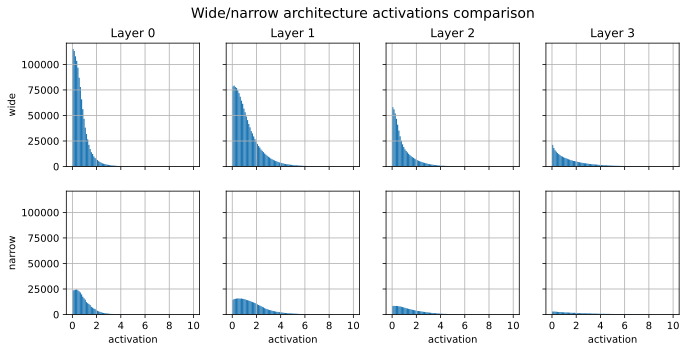

In [33]:
compare_configs('wide', 'narrow', test_batch,
                title='Wide/narrow architecture activations comparison')

Заметно, что у узкой модели активации меньше по величине, чем у широкой. Вероятно это связано с тем, что в широкой модели больше параметров, и они медленнее оптимизируются.

Number of zero activations:
	deep = [627406, 770639, 359323, 150965]
	shallow = [619621, 649012, 297481, 153818]


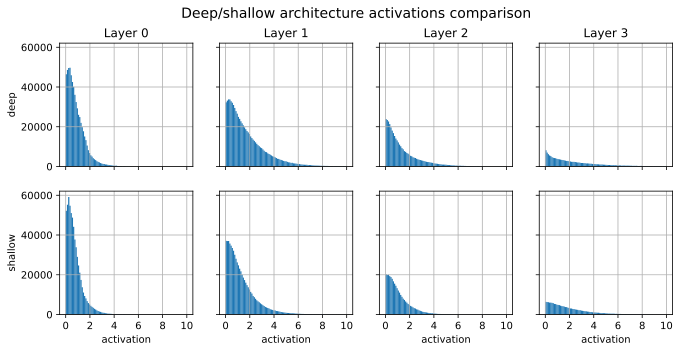

In [34]:
compare_configs('deep', 'shallow', test_batch,
                title='Deep/shallow architecture activations comparison')

Значительной разницы в активациях между глубокой и мелкой архитектурами не заметно. Попробуем убрать из них ResConnect.

Number of zero activations:
	deep-bn = [588313, 558941, 260773, 129253]
	shallow-bn = [587373, 520491, 233549, 139387]


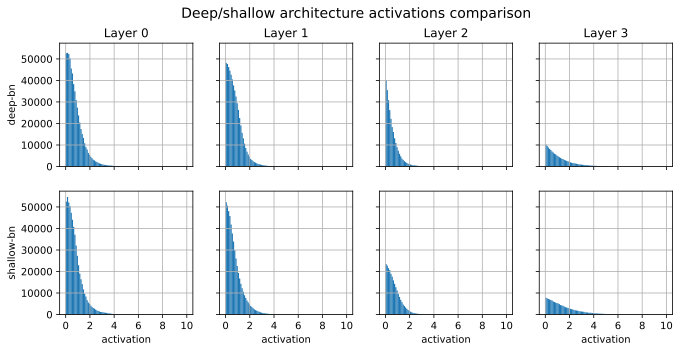

In [35]:
compare_configs('deep-bn', 'shallow-bn', test_batch,
                title='Deep/shallow architecture activations comparison')

Разница стала чуть более заметна, для глубокой архитектуры распределение имеет более острый пик в 0.

Number of zero activations:
	default = [611896, 679721, 311031, 155902]
	batch_norm = [581235, 490802, 251431, 136606]


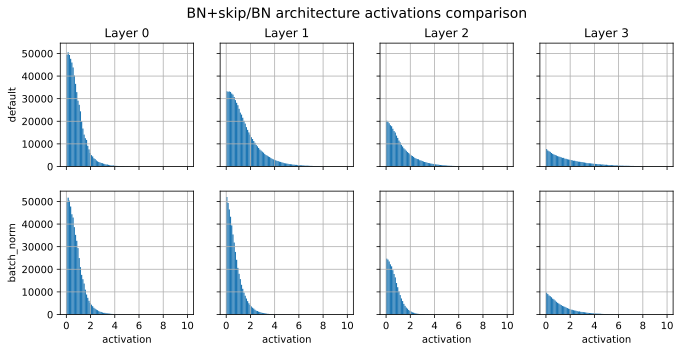

In [36]:
compare_configs('default', 'batch_norm', test_batch,
                title='BN+skip/BN architecture activations comparison')

Здесь можно заметить, что распределения для архитектуры без ResConnection имеют более короткие хвосты, меньшую дисперсию. 

Number of zero activations:
	default = [611896, 679721, 311031, 155902]
	res_connect = [629235, 412886, 195387, 84645]


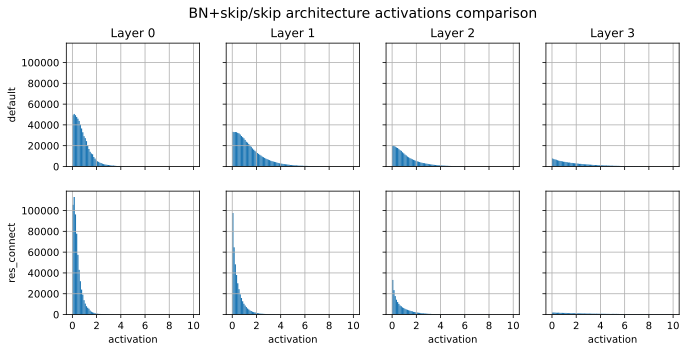

In [37]:
compare_configs('default', 'res_connect', test_batch,
                title='BN+skip/skip architecture activations comparison')

Заметно, что архитектура без BatchNorm имеет намного более острый пик около 0 на первых 2 слоях, а на последнем слое распределение выравнивается.

Number of zero activations:
	default = [611896, 679721, 311031, 155902]
	dropout = [532702, 492895, 227341, 75213]


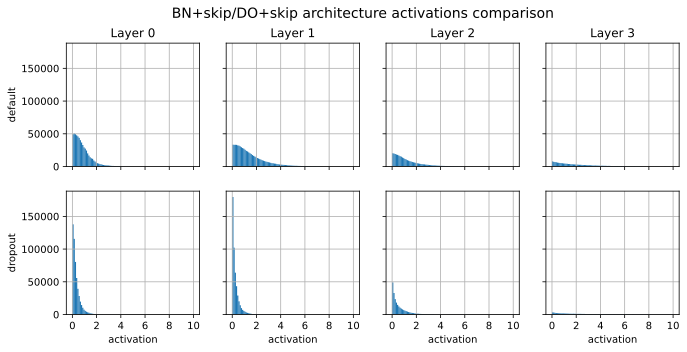

In [38]:
compare_configs('default', 'dropout', test_batch,
                title='BN+skip/DO+skip architecture activations comparison')

Сравнивая распределения архитектур с BatchNorm и с Dropout можно сказать, что у второй распределения имеют более выраженный пик в 0, который уменьшается с увеличением глубины слоя. У архитектуры с BatchNorm распределение больше напоминает половину колокола нормального распределения, который с увеличением глубины слоя все больше сглаживается.

Number of zero activations:
	dropout = [532702, 492895, 227341, 75213]
	res_connect = [629235, 412886, 195387, 84645]


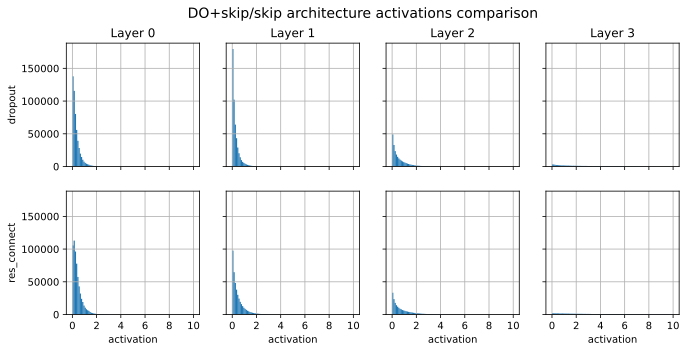

In [39]:
compare_configs('dropout', 'res_connect', test_batch,
                title='DO+skip/skip architecture activations comparison')

Можно заметить, что добавление DropOut к ResConnect незначительно меняет распределение активаций. При использовании DropOut пик в нуле чуть более выражен.

Number of zero activations:
	xavier_uniform_init = [588746, 773315, 319481, 152568]
	kaiming_uniform_init = [585598, 716141, 324282, 157053]


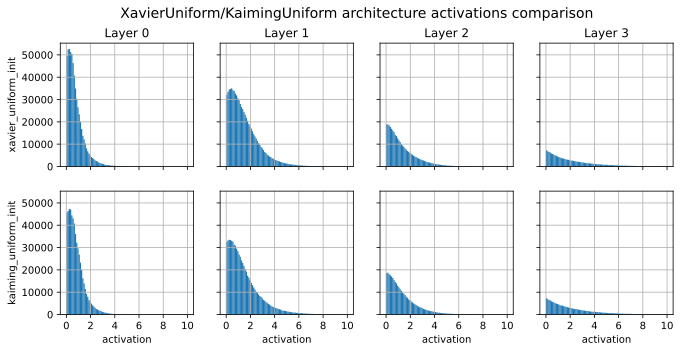

In [40]:
compare_configs('xavier_uniform_init', 'kaiming_uniform_init', test_batch,
                title='XavierUniform/KaimingUniform architecture activations comparison')

Number of zero activations:
	xavier_normal_init = [611116, 738818, 318105, 154542]
	kaiming_normal_init = [597198, 783962, 320445, 156250]


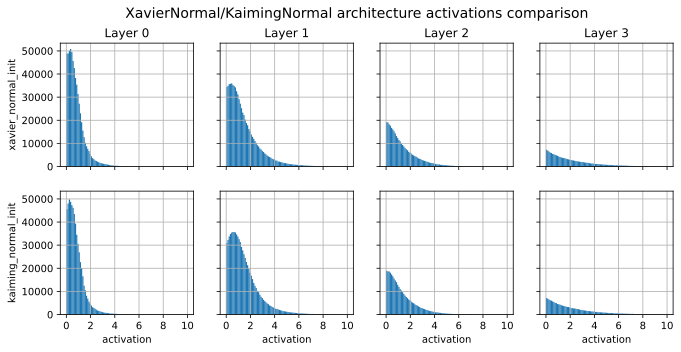

In [41]:
compare_configs('xavier_normal_init', 'kaiming_normal_init', test_batch,
                title='XavierNormal/KaimingNormal architecture activations comparison')

Можно сказать, что распределение активаций не сильно зависит от начальной инициализации.

Number of zero activations:
	default = [611896, 679721, 311031, 155902]
	sgd = [635188, 739340, 331184, 150243]


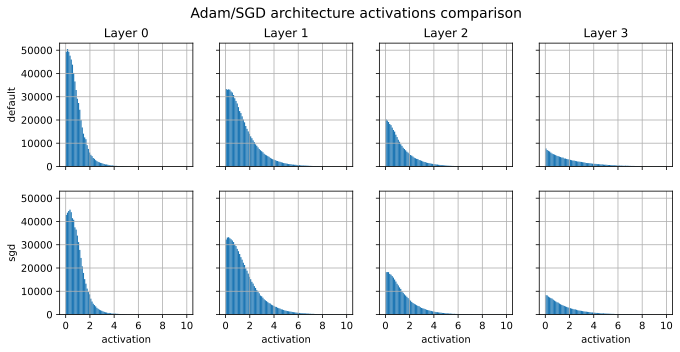

In [42]:
compare_configs('default', 'sgd', test_batch,
                title='Adam/SGD architecture activations comparison')

При правильно подобранных параметров итоговое распределение активаций не зависит также и от оптимизатора.

__Выводы__: Чем шире и глубже архитектура, тем ближе активации будут смещаться к 0. Использование BatchNorm делает распределения больше похожими на правый колокол нормального распределение с центром в 0. Это ожидаемо, так как батч нормализация контролирует среднее и дисперсию выходов сверточных слоев. DropOut немного уменьшает пик в 0, но в целом незначительно влияет на распределение. Инициализация и оптимизаторы по результатам экспериментов не влияют на распределение активаций.

### Функции для отрисовки 3D графиков

In [43]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

def plot_3d(config_names, test_batch, titles=None):
 
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{'type': 'surface'}, {'type': 'surface'}]],
        subplot_titles=titles)

    for i, name, in enumerate(config_names):
        
        save_dict = torch.load(f"saved_models/{name}")
        model = CustomCNN(BaseBlock, **save_dict['config']['cnn_config']).to(device)
        model.load_state_dict(save_dict['state_dict'])
        
        model.eval()
        with torch.no_grad():
            data, target = test_batch
            data = data.to(device)
            output = model.forward(data)
            activations = model.activations

        step = save_dict['config']['cnn_config']['layers_config'][0][0]
        activations = [activations[0]] + [act for block in activations[1:] for act in block]
        activations = [t.to('cpu').flatten() for t in activations]

        bin_edges = np.linspace(0, 10, 200)

        bin_centers = centers(bin_edges)

        counts = []
        for act in activations:
            h = np.histogram(act[act > 1e-8], bins=bin_edges)
            counts.append(h[0])
        counts = np.stack(counts)
        
        layers = list(range(len(activations)))
        fig.add_trace(
            go.Surface(x=bin_centers, y=layers, z=counts, showscale=False),
            row=1, col=i+1)
    
    fig.update_layout(title='Activations distribution for each layer',
                      scene=dict(
                          xaxis_title='activation',
                          yaxis_title='layer',
                          zaxis_title='count'),
                     scene2=dict(
                          xaxis_title='activation',
                          yaxis_title='layer',
                          zaxis_title='count'))
    fig.show()

### Распределения по всем слоям
На 3D графике можно красиво изобразить распредления активаций для всех сверточных слоев сети.

Нарисуем такие графики для наиболее интересных пар архитектур.

In [44]:
plot_3d(['wide', 'narrow'], test_batch, titles=['Wide', 'Narrow'])

Для широкой и узкой архитектуры распределения похоже по форме и отличаются только масштабом и величиной хвоста.

In [45]:
plot_3d(['deep-bn', 'shallow-bn'], test_batch, titles=['Deep', 'Shallow'])

Заметно, что для глубокой архитектуры активации чуть больше смещены в сторону 0, особенно после последних сверток в слое.

In [46]:
plot_3d(['default', 'batch_norm'], test_batch, titles=['BatchNorm+skip', 'BatchNorm'])

Можно заметить, что ResConnection добавляет пики на каждом 2 слое. Это логично, так как после каждой второй свертки и прибавляется вход с первой свертки.

In [47]:
plot_3d(['res_connect', 'dropout'], test_batch, titles=['skip', 'skip+Dropout'])

В этом сравнении можно заметить еще более выраженные пики после прибавления ResConnection. При использовании DropOut эти пики чуть более выражены.